# Filtering

Notebook shows how to filter the merges generated from the fragment network using calculated descriptors and 3D methods.

## Imports

In [1]:
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import AllChem, Crippen, Draw, PandasTools, QED, rdFMCS, rdForceFieldHelpers, rdMolDescriptors, rdmolops, PyMol, rdmolfiles, rdShapeHelpers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import time

# import scripts
sys.path.insert(1, '/home/sabsr3/xchem/fragment_network_merges/scripts')
from filter import *  # will prompt for password to access database

In [2]:
RDLogger.DisableLog('rdApp.*') 

## Load the data

In [3]:
# read dictionary from file
file_to_read = open("/home/sabsr3/xchem/fragment_network_merges/data/fraga_expansions.pickle", "rb")
fraga_expansions = pickle.load(file_to_read)

In [4]:
# load test data csv to get the fragment smiles (for reference later)
test_data = pd.read_csv('testset.csv').drop(['Unnamed: 0'], axis=1)
test_data.head()

,molecule,molecule_smiles,fraga,fraga_smiles,fragb,fragb_smiles
0,x0678,O=C(CC1CCCCC1)Nc1cccnc1,x0107,CC(=O)Nc1cnccc1C,x0678t,NC(=O)CC1CCCCC1
1,x2569,N#Cc1cncc(CC(=O)Nc2cccnc2)c1,x0305,CCNc1ccc(C#N)cn1,x2569t,NC(=O)Cc1cccnc1
2,x2572,Cc1ccncc1NC(=O)Cc1cccc(C#N)c1,x0107,CC(=O)Nc1cnccc1C,x2572t,N#Cc1cccc(CC(N)=O)c1
3,x2608,Cc1ccc(NC(=O)Nc2cccnc2)s1,x0434,O=C(Nc1ccccc1)Nc1cccnc1,x2608t,Cc1ccc(NC(N)=O)s1
4,x2643,O=C(Cc1ccc(Cl)s1)Nc1cccnc1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,x2643t,NC(=O)Cc1ccc(Cl)s1


## Create dataframe containing the expansions

In [5]:
fragment_a = {}
fragment_b = {}

for _, row in test_data.iterrows():
    fragment_a[row['fraga']] = row['fraga_smiles']
    fragment_b[row['fragb']] = row['fragb_smiles']

In [6]:
df_smiles = []
df_synthons = []
df_merges = []
df_fraga_ids = []
df_fragb_ids = []
df_fraga = []
df_fragb = []

for merge in fraga_expansions:
    for synthon in fraga_expansions[merge]:
        for smiles in fraga_expansions[merge][synthon]:
            df_smiles.append(smiles)
            df_synthons.append(synthon)
            df_merges.append(merge)
            fraga_id, fragb_id = merge.split('_')[0], merge.split('_')[1]
            df_fraga_ids.append(fraga_id)
            df_fragb_ids.append(fragb_id)
            df_fraga.append(fragment_a[fraga_id])
            df_fragb.append(fragment_b[fragb_id])

In [7]:
d = {'Fragment A': df_fraga_ids, 'Fragment A smiles': df_fraga, 'Fragment B': df_fragb_ids, 'Fragment B smiles': df_fragb, 'Merge': df_merges, 'Merge smiles': df_smiles, 'Synthon smiles': df_synthons}
expansions = pd.DataFrame(d)
expansions.head()

,Fragment A,Fragment A smiles,Fragment B,Fragment B smiles,Merge,Merge smiles,Synthon smiles
0,x0107,CC(=O)Nc1cnccc1C,x0678t,NC(=O)CC1CCCCC1,x0107_x0678t,NC(=O)CN1CCNc2cc3c(cc21)OCO3,NC(=O)C[Xe]
1,x0107,CC(=O)Nc1cnccc1C,x0678t,NC(=O)CC1CCCCC1,x0107_x0678t,NC(=O)CN1C(=O)c2cccnc2S1(=O)=O,NC(=O)C[Xe]
2,x0107,CC(=O)Nc1cnccc1C,x0678t,NC(=O)CC1CCCCC1,x0107_x0678t,NC(=O)CN1C(=O)CNCc2ccccc21,NC(=O)C[Xe]
3,x0107,CC(=O)Nc1cnccc1C,x0678t,NC(=O)CC1CCCCC1,x0107_x0678t,CC(=O)Nc1ccc2nc(CC(N)=O)cc(C)c2c1,NC(=O)C[Xe]
4,x0107,CC(=O)Nc1cnccc1C,x0678t,NC(=O)CC1CCCCC1,x0107_x0678t,NC(=O)Cn1cnc2cc3c(cc21)OCCO3,NC(=O)C[Xe]


In [8]:
# add molecule columns to df
PandasTools.AddMoleculeColumnToFrame(expansions, smilesCol='Merge smiles', molCol='Merge molecule')
PandasTools.AddMoleculeColumnToFrame(expansions, smilesCol='Synthon smiles', molCol='Synthon molecule')

,Fragment A,Fragment A smiles,Fragment B,Fragment B smiles,Merge,Merge smiles,Synthon smiles,Merge molecule,Synthon molecule
0,x0107,CC(=O)Nc1cnccc1C,x0678t,NC(=O)CC1CCCCC1,x0107_x0678t,NC(=O)CN1CCNc2cc3c(cc21)OCO3,NC(=O)C[Xe],,
1,x0107,CC(=O)Nc1cnccc1C,x0678t,NC(=O)CC1CCCCC1,x0107_x0678t,NC(=O)CN1C(=O)c2cccnc2S1(=O)=O,NC(=O)C[Xe],,

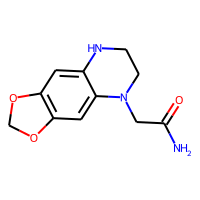
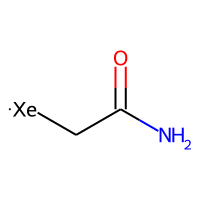
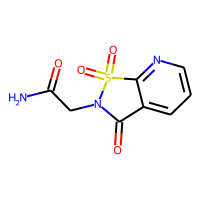
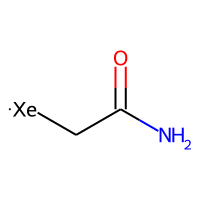

In [9]:
expansions.head(2)

## Filter by descriptors

A number of descriptors are calculated for the merges. Violations are recorded according to whether the molecule violates a certain criteria (e.g. MW > 350). Molecules are ruled out if they result in > 2 violations.

(can change these)

In [10]:
# create function to calculate properties
def calc_properties(df, molCol='Merge molecule'):
    df['Molecular weight'] = df[molCol].apply(rdMolDescriptors.CalcExactMolWt)
    df['AlogP'] = df[molCol].apply(Crippen.MolLogP)
    df['HBA'] = df[molCol].apply(rdMolDescriptors.CalcNumHBA)
    df['HBD'] = df[molCol].apply(rdMolDescriptors.CalcNumHBD)
    df['PSA'] =  df[molCol].apply(rdMolDescriptors.CalcTPSA)
    df['Rotatable bonds'] = df[molCol].apply(rdMolDescriptors.CalcNumRotatableBonds)
    df['Aromatic rings'] = df[molCol].apply(rdMolDescriptors.CalcNumAromaticRings)

In [11]:
# add property columns to df
calc_properties(expansions)

In [12]:
# create function to calculate the number of violations based on calculated properties
def frag_filter(df):
    num_violations = []
    for _, row in df.iterrows():
        violations = 0
        if row['Molecular weight'] > 350: violations += 1
        if row['AlogP'] > 3: violations += 1
        if row['HBA'] > 3: violations += 1
        if row['HBD'] > 3: violations += 1
        if row['PSA'] > 100: violations += 1
        if row['Rotatable bonds'] > 8: violations += 1
        if row['Aromatic rings'] > 2: violations += 1
        num_violations.append(violations)
    df['Violations'] = num_violations

# apply filter function to dataframe
frag_filter(expansions)

# count the number of violations
expansions['Violations'].value_counts()

1    25769
0    20978
2     7708
3     2456
4      540
5       15
Name: Violations, dtype: int64

In [13]:
# remove compounds that violate more than two rules
num_rows = len(expansions)
print(f'Number of compounds: {num_rows}')
expansions = expansions[expansions.Violations <= 2].reset_index(drop=True)
print(f'Number of compounds after filtering: {len(expansions)}')
print(f'Number of compounds removed: {num_rows - len(expansions)}')

Number of compounds: 57466
Number of compounds after filtering: 54455
Number of compounds removed: 3011


## 3D filtering

Used constrained embedding to filter the merges. The proposed molecules are embedded while constraining the atoms that came from their respective fragment A and fragment B (3D coordinates for these atoms are added from the original mol files). This filters out many molecules with bad conformations as the embedding will fail.

(code to get the structures gets quite convoluted - fix)

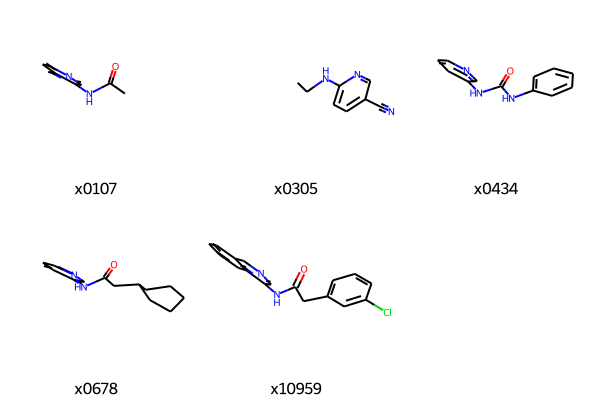

In [14]:
# get the fragment A file paths for the mol files
path = '/home/sabsr3/xchem/fragment_network_merges/data/Mpro/aligned/Mpro-xFRAG_ID_0A/Mpro-xFRAG_ID_0A.mol' # uses the chain A file
fraga_paths = [path.replace('xFRAG_ID', Id) for Id in list(fragment_a.keys())]

# get the molecules from the files
fraga_mols = []
for file_path in fraga_paths:
    for mol in Chem.SDMolSupplier(file_path):
        fraga_mols.append(mol)

# visualise the fragments
Draw.MolsToGridImage(fraga_mols, legends=list(fragment_a.keys()))

In [15]:
# remove 't' from fragment b id to get file paths
get_fb = []
for fb in list(fragment_b.keys()):
    get_fb.append(fb.replace('t', ''))

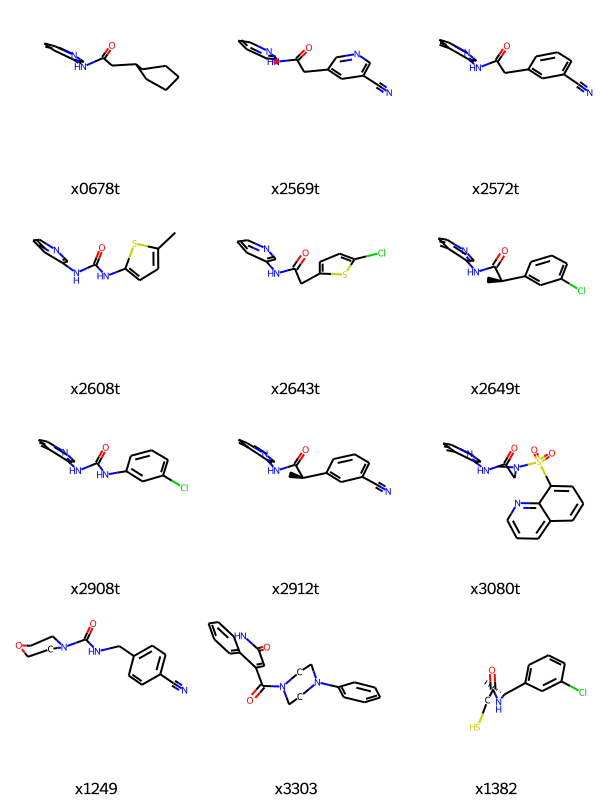

In [16]:
# get the fragment B file paths for the mol files
path = '/home/sabsr3/xchem/fragment_network_merges/data/Mpro/aligned/Mpro-xFRAG_ID_0A/Mpro-xFRAG_ID_0A.mol' # uses the chain A file
fragb_paths = [path.replace('xFRAG_ID', Id) for Id in get_fb]

# get the molecules from the files
fragb_mols = []
for file_path in fragb_paths:
    for mol in Chem.SDMolSupplier(file_path):
        fragb_mols.append(mol)

# visualise the fragments
Draw.MolsToGridImage(fragb_mols, legends=list(fragment_b.keys()))

In [65]:
# remove 't' from fragment b id to get file paths
get_all_fb = []
for fb in expansions['Fragment B']:
    get_all_fb.append(fb.replace('t', ''))

In [66]:
def to_dict(ids, mols):
    d = {}
    for i, m in zip(ids, mols):
        d[i] = m
    return d

fraga_dict = to_dict(list(fragment_a.keys()), fraga_mols)
fragb_dict = to_dict(get_fb, fragb_mols)

In [69]:
# get the molecules required to do the embedding
expanded = [i for i in expansions['Merge molecule']]
fraga_reference = [fraga_dict[i] for i in expansions['Fragment A']]
fragb_reference = [fragb_dict[i] for i in get_all_fb]
synths = [i for i in expansions['Synthon smiles']]

In [18]:
# start = time.time()

# embedded_merges = {}

# for i, (fA, fB, m, s) in enumerate(zip(fraga_reference, fragb_reference, expanded, synths)):
#     fragA = Chem.Mol(fA)
#     fragB = Chem.Mol(fB)
#     full_merge = Chem.Mol(m)
#     syn = Chem.Mol(s)
#     try:
#         embedded = Chem.Mol(embedding(fragA, fragB, full_merge, syn))
#         embedded_merges[i] = embedded
#     except:
#         pass

# end = time.time()
# print(end-start)

In [19]:
# embedded_file_to_write = open("embedded_merges.pickle", "wb")
# pickle.dump(embedded_merges, embedded_file_to_write)

In [20]:
# read dictionary from file
embedded_file_to_read = open("/home/sabsr3/xchem/fragment_network_merges/data/embedded_merges.pickle", "rb")
embedded_merges = pickle.load(embedded_file_to_read)
print(len(embedded_merges))

5303


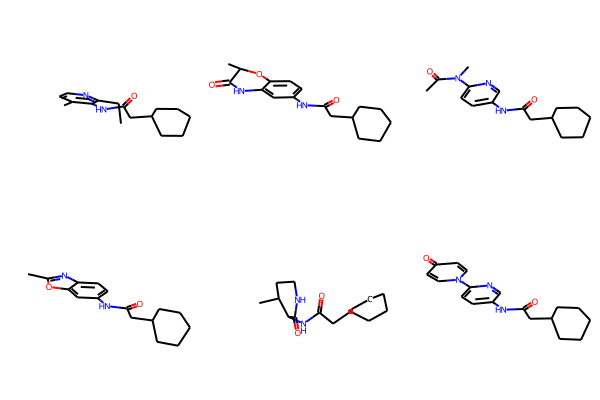

In [21]:
Draw.MolsToGridImage(list(embedded_merges.values())[:6])

In [25]:
energies = {}

# calculate the energies of all of the successful embedded molecules
for i in embedded_merges:
    energy = calc_energy(embedded_merges[i])
    energies[i] = energy

In [26]:
indices = list(embedded_merges.keys())
# get the original molecules that were successfully embedded
successful_mols = [expanded[i] for i in indices]

# unconstrained_file_to_write = open("unconstrained_energies.pickle", "wb")
# pickle.dump(avg_unconstrained_energies, unconstrained_file_to_write)

# read dictionary from file
unconstrained_file_to_read = open("/home/sabsr3/xchem/fragment_network_merges/data/unconstrained_energies.pickle", "rb")
avg_unconstrained_energies = pickle.load(unconstrained_file_to_read)
print(len(avg_unconstrained_energies))

5303


In [27]:
filtered = {}
ratios = []

# remove molecules where the constrained energy is >10-fold greater than average unconstrained
for cons, uncons in zip(energies, avg_unconstrained_energies):
    constrained = energies[cons]
    unconstrained = avg_unconstrained_energies[uncons]
    if constrained < unconstrained:
        filtered[cons] = constrained
    else:
        ratio = constrained / unconstrained
        ratios.append(ratio)
        if ratio < 10:
            filtered[cons] = constrained

print(len(filtered))

5301


## Shape protrusion distance

Work out which fragments the merge has come from
Calculate the overlap with the 

In [28]:
protein = rdmolfiles.MolFromPDBFile('/home/sabsr3/xchem/fragment_network_merges/data/Mpro/aligned/Mpro-x3080_0A/Mpro-x3080_0A_apo-desolv.pdb')

In [29]:
protrude_dists = {}

for i in tqdm(embedded_merges):
    mol = embedded_merges[i]
    protrude_dist = rdShapeHelpers.ShapeProtrudeDist(mol, protein)
    protrude_dists[i] = protrude_dist

100%|██████████| 5303/5303 [02:02<00:00, 43.12it/s]


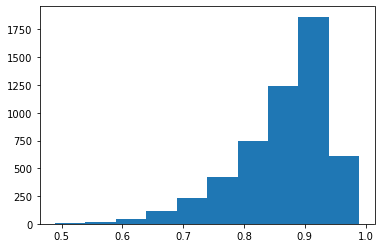

In [30]:
plt.hist(protrude_dists.values())
plt.show()

In [31]:
# ShapeProtrudeDist is the percentage of the smaller molecule that protrudes from the larger
count1 = 0
count2 = 0
count3 = 0
count4 = 0
for i in protrude_dists.values():
    if i > 0.8:
        count1 += 1
    if i > 0.85:
        count2 += 1
    if i > 0.9:
        count3 += 1
    if i > 0.95:
        count4 += 1

print('Number of compounds that overlap by less than 20%:', count1, '/', len(protrude_dists))
print('Number of compounds that overlap by less than 15%:', count2, '/', len(protrude_dists))
print('Number of compounds that overlap by less than 10%:', count3, '/', len(protrude_dists))
print('Number of compounds that overlap by less than 5%:', count4, '/', len(protrude_dists))

Number of compounds that overlap by less than 20%: 4332 / 5303
Number of compounds that overlap by less than 15%: 3485 / 5303
Number of compounds that overlap by less than 10%: 2107 / 5303
Number of compounds that overlap by less than 5%: 329 / 5303


In [32]:
nonoverlap_mols  = []

for i in tqdm(embedded_merges):
    mol = embedded_merges[i]
    protrude_dist = rdShapeHelpers.ShapeProtrudeDist(mol, protein)
    if protrude_dist > 0.9:
        nonoverlap_mols.append(mol)

# w = Chem.SDWriter('/home/sabsr3/xchem/fragment_network_merges/data/filtered_mols.sdf')
# for mol in nonoverlap_mols: w.write(mol)

# w = Chem.rdmolfiles.SmilesWriter('/home/sabsr3/xchem/fragment_network_merges/data/filtered_mols.smi')
# for mol in nonoverlap_mols: w.write(mol)

100%|██████████| 5303/5303 [01:58<00:00, 44.73it/s]


In [34]:
nonoverlap_mols_dict  = {}

for i in tqdm(embedded_merges):
    mol = embedded_merges[i]
    protrude_dist = rdShapeHelpers.ShapeProtrudeDist(mol, protein)
    if protrude_dist > 0.9:
        nonoverlap_mols_dict[i] = mol

100%|██████████| 5303/5303 [01:58<00:00, 44.74it/s]


In [47]:
fraga_filtered_id = [df_fraga_ids[i] for i in list(nonoverlap_mols_dict.keys())]
fragb_filtered_id = [df_fragb_ids[i] for i in list(nonoverlap_mols_dict.keys())]

fa_write = open("fraga_filtered.pickle", "wb")
pickle.dump(fraga_filtered_id, fa_write)

fb_write = open("fragb_filtered.pickle", "wb")
pickle.dump(fragb_filtered_id, fb_write)

In [70]:
# amount of overlap depends on which protein pdb structure is used
# many of the fragment B structures overlap with the protein
fBs = [fragb_reference[i] for i in indices]
fB_dists = []
for f in tqdm(fBs):
    dist = rdShapeHelpers.ShapeProtrudeDist(f, protein)
    fB_dists.append(dist)

100%|██████████| 5303/5303 [01:55<00:00, 45.94it/s]


(array([ 864.,    0.,    0.,    0.,    0.,    0.,  884., 1840., 1400.,
         315.]),
 array([0.88340807, 0.89403374, 0.9046594 , 0.91528507, 0.92591074,
        0.9365364 , 0.94716207, 0.95778774, 0.9684134 , 0.97903907,
        0.98966473]),
 <BarContainer object of 10 artists>)

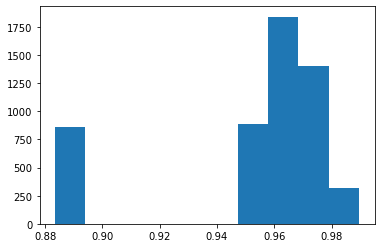

In [71]:
plt.hist(fB_dists)

In [88]:
# x1382 overlaps with the pdb file in its folder?
p = rdmolfiles.MolFromPDBFile('/home/sabsr3/xchem/fragment_network_merges/data/Mpro/aligned/Mpro-x1382_0A/Mpro-x1382_0A_apo-desolv.pdb')
rdShapeHelpers.ShapeProtrudeDist(fragb_mols[11], p)

0.8591437632135307

## Compare filtered molecules with original dataset

In [36]:
filtered_df = pd.DataFrame({'Filtered molecules': nonoverlap_mols})

In [37]:
calc_properties(filtered_df, molCol='Filtered molecules')

,Filtered molecules,Molecular weight,AlogP,HBA,HBD,PSA,Rotatable bonds,Aromatic rings
0,,260.188863,3.86132,2,1,41.99,4,1
1,,272.152478,4.04512,3,1,55.13,3,2

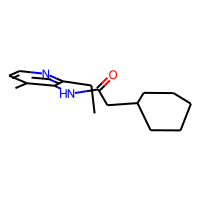
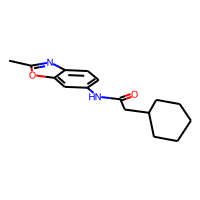

In [39]:
filtered_df.head(2)

In [41]:
features = ['Molecular weight', 'AlogP', 'HBA', 'HBD', 'PSA', 'Rotatable bonds', 'Aromatic rings']

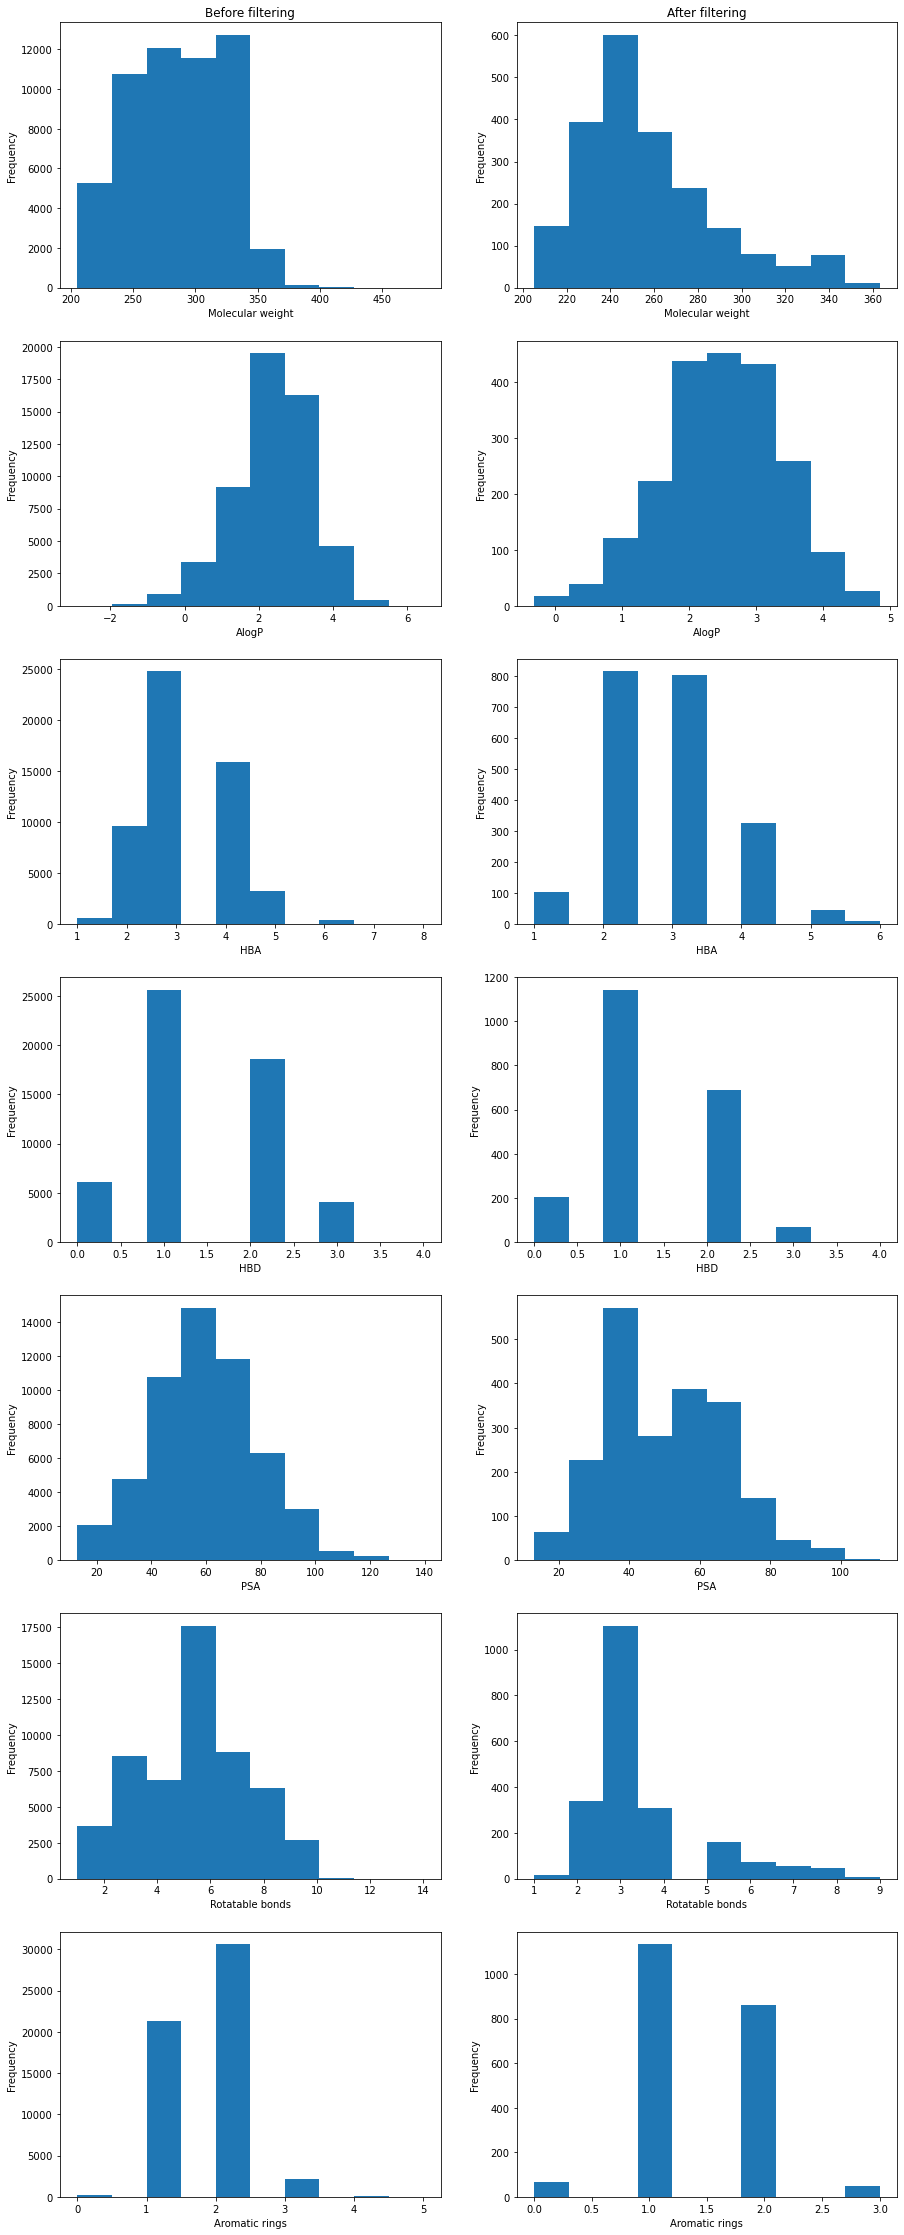

In [52]:
fig, axs = plt.subplots(7, 2, figsize = (15, 40))
for i, feature in enumerate(features):
    axs[i, 0].hist(expansions[feature])
    axs[i, 1].hist(filtered_df[feature])
    axs[i, 0].set(xlabel=feature, ylabel='Frequency')
    axs[i, 1].set(xlabel=feature, ylabel='Frequency')
axs[0, 0].set_title('Before filtering')
axs[0, 1].set_title('After filtering')

plt.show()

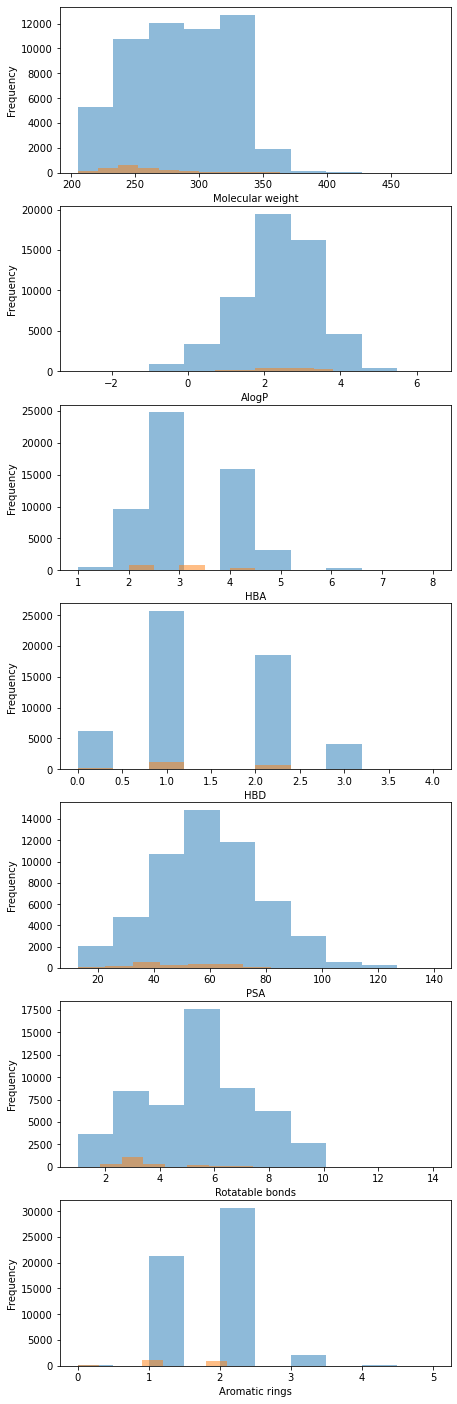

In [54]:
fig, axs = plt.subplots(7, 1, figsize = (7, 25))
for i, feature in enumerate(features):
    axs[i].hist(expansions[feature], alpha=0.5)
    axs[i].hist(filtered_df[feature], alpha=0.5)
    axs[i].set(xlabel=feature, ylabel='Frequency')


plt.show()